In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pulp
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("VSRR_Provisional_Drug_Overdose_Death_Counts.csv")

In [3]:
#Clean VSRR data
df["Data Value"] = pd.to_numeric(df["Data Value"].str.replace(",",""))
df["Predicted Value"] = pd.to_numeric(df["Predicted Value"].str.replace(",",""))
month_mapping = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12}
df["Month"] = df["Month"].map(month_mapping)
df["End Date"] = pd.to_datetime(df["Month"].astype(str) + "/" + "1" + "/" + df["Year"].astype(str)) + pd.DateOffset(months=1) - timedelta(days=1)
df["Start Date"] = pd.to_datetime(df["Month"].astype(str) + "/" + "1" + "/" + (df["Year"]-1).astype(str)) + pd.DateOffset(months=1)

#Carvout for New York City
df = df.rename(columns = {"State Name": "Region"})
df["Region"] = np.where(df["Region"] != "New York", df["Region"], "Upstate New York")
df["State"] = np.where(df["State"] != "YC", df["State"], "NY")

#Confine analysis on regions of interst 
regions_of_interest = ["West Virginia", "Alabama", "Georgia", "Kentucky", "Maryland", "Mississippi", "Upstate New York", "North Carolina", "Ohio", "Pennsylvania", "South Carolina", "Tennessee", "Virginia", "California"]
df = df[df["Region"].isin(regions_of_interest)]

#Convert data from Long to Wide 
#Melt and Pivot Overdose Deatj Records
od_df = df[df["Indicator"] == "Number of Drug Overdose Deaths"]
vals = ["Data Value", "Predicted Value"]
ids = [element for element in od_df.columns.tolist() if element not in vals]
od_df = pd.melt(od_df, id_vars=ids, value_vars=vals)
od_df = pd.DataFrame(od_df.pivot(index = ["State", "Region", "Year", "Month", "Start Date", "End Date"], columns = "variable", values = "value").to_records()).rename(columns = {"Data Value": "Reported Number of Drug Overdose Deaths", "Predicted Value": "Predicted Number of Drug Overdose Deaths"})

#Pivot all other records
other_df = df[df["Indicator"] != "Number of Drug Overdose Deaths"]
other_df = pd.DataFrame(other_df.pivot(index = ["State", "Region", "Year", "Month", "Start Date", "End Date"], columns = "Indicator", values = "Data Value").to_records())

death_df = od_df.merge(other_df, how = 'inner',  on = ["State", "Region", "Year", "Month", "Start Date", "End Date"])

In [4]:
def sliding_windows(kernel, num_constraining_eqs):
    kernel = np.asarray(kernel)
    p = np.zeros(num_constraining_eqs-1,dtype=kernel.dtype)
    b = np.concatenate((p,kernel,p))
    s = b.strides[0]
    strided = np.lib.stride_tricks.as_strided
    return strided(b[num_constraining_eqs-1:], shape=(num_constraining_eqs,len(kernel)+num_constraining_eqs-1), strides=(-s,s))

# Slide 11: Initial Python Implementation 

In [8]:
period = 12
regions = death_df["Region"].unique()
indicies = ["State", "FIPS", "Region", "Year", "Month", "Start Date", "End Date", "Percent with drugs specified"]
targets = [element for element in death_df.columns.tolist() if element not in indicies]

monthly_deaths_df = pd.DataFrame()
for region in regions:
    series = death_df[death_df["Region"] == region].sort_values(by='End Date')
    for target in targets:
        sol = series[target].dropna().to_numpy()
        if (len(sol) < 2):
            marginal_values = np.empty(len(series.index))
            marginal_values[:] = np.nan
            series["Estimated Monthly Marginal " + target] = marginal_values
            continue
        coef = sliding_windows(np.ones(period), len(sol))
        #pulp Linear Algebra Solver yeilds a solution not guaranteed to be the correct solution but all the values
        #it produces will be non-negative, discrete and yeild the values in the dataset when summed across a 12 month window
        mod = pulp.LpProblem(region.replace(" ", "_") + ":" +  target.replace(" ", "_"))
        
        #set up contraining inequalities
        #constrain monthly death tally values to integers greater than or equal to 0 
        vars = pulp.LpVariable.dicts('x', range(len(coef[0])), lowBound=0, cat='Integer')
        
        #set up contraining equations
        for row, rhs in zip(coef, sol):
            mod += sum([row[i]*vars[i] for i in range(len(row))]) == rhs
            
        mod.solve()
        
        #currently discarding the leading 11 values which dont have corresponding 12 month rolling sums
        #could possibly rewrite this section to keep them with null values for the 12 month rolling sums in the future
        marginal_values = [vars[i].value() for i in range(len(coef[0]))][(period -1):]
        series["Estimated Monthly Marginal " + target] = np.pad(marginal_values, (len(series.index)-len(marginal_values),0), 'constant', constant_values=(np.nan))
    
    monthly_deaths_df = pd.concat([monthly_deaths_df, series])

In [9]:
#Sanity Check 1: Algorithm doesnt return any negative values 
#Table should be empty
calculated_columns = [i for i in monthly_deaths_df.columns if i.startswith("Estimated Monthly Marginal ")]
monthly_deaths_df[((monthly_deaths_df[calculated_columns] >= 0).all(1) == False)][["Region", "Start Date", "End Date"] + calculated_columns].dropna()

,Region,Start Date,End Date,Estimated Monthly Marginal Reported Number of Drug Overdose Deaths,Estimated Monthly Marginal Predicted Number of Drug Overdose Deaths,Estimated Monthly Marginal Cocaine (T40.5),Estimated Monthly Marginal Heroin (T40.1),Estimated Monthly Marginal Methadone (T40.3),Estimated Monthly Marginal Natural & semi-synthetic opioids (T40.2),"Estimated Monthly Marginal Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)","Estimated Monthly Marginal Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)",Estimated Monthly Marginal Number of Deaths,"Estimated Monthly Marginal Opioids (T40.0-T40.4,T40.6)",Estimated Monthly Marginal Psychostimulants with abuse potential (T43.6),"Estimated Monthly Marginal Synthetic opioids, excl. methadone (T40.4)"


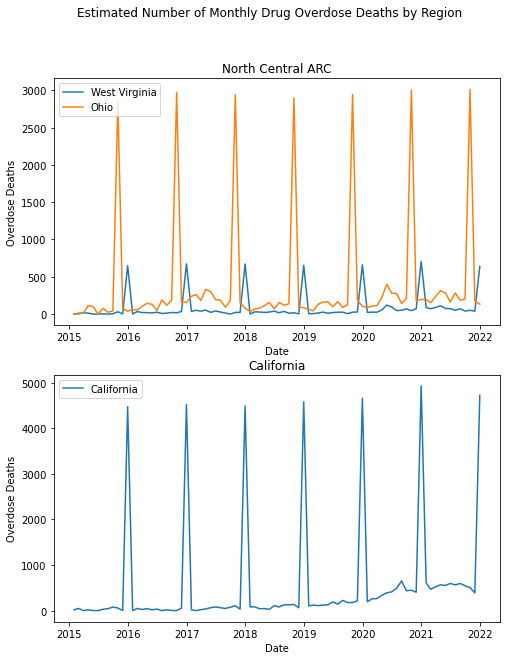

In [10]:
sub_regions = {#"Northern ARC": ["Maryland", "Upstate New York", "Ohio", "Pennsylvania"],
"North Central ARC": ["West Virginia", "Ohio"],
#"Central ARC": ["West Virginia", "Kentucky", "Tennessee", "Virginia"],
#"South Central ARC": ["North Carolina", "Tennessee", "Virginia"],
#"Southern ARC": ["Alabama", "Georgia", "Mississippi", "South Carolina"],
"California": ["California"]}

feature_of_interest = "Estimated Monthly Marginal Reported Number of Drug Overdose Deaths"

figures_per_row = 1

fig, axs = plt.subplots(int(len(sub_regions.keys())/figures_per_row), figures_per_row, figsize=(8,10))
fig.suptitle("Estimated Number of Monthly Drug Overdose Deaths by Region")

for index, sub_region in enumerate(sub_regions.keys()):
    for region in sub_regions[sub_region]:
        axs[index].plot(monthly_deaths_df[monthly_deaths_df["Region"] == region]["End Date"], monthly_deaths_df[monthly_deaths_df["Region"] == region][feature_of_interest], label = region)
    
    axs[index].set_title(sub_region)
    axs[index].legend(loc="upper left")
    axs[index].set(title= sub_region, xlabel='Date', ylabel='Overdose Deaths')
    # change font size

# Slide 14 : Python Implementation of More Constraints

In [15]:
period = 12
volatility_factor = 1.2 # must be between 1 and period
regions = death_df["Region"].unique()
indicies = ["State", "FIPS", "Region", "Year", "Month", "Start Date", "End Date", "Percent with drugs specified"]
targets = [element for element in death_df.columns.tolist() if element not in indicies]

monthly_deaths_df = pd.DataFrame()
for region in regions:
    series = death_df[death_df["Region"] == region].sort_values(by='End Date')
    for target in targets:
        sol = series[target].dropna().to_numpy()
        if (len(sol) < 2):
            marginal_values = np.empty(len(series.index))
            marginal_values[:] = np.nan
            series["Estimated Monthly Marginal " + target] = marginal_values
            continue
        coef = sliding_windows(np.ones(period), len(sol))
        #pulp Linear Algebra Solver yeilds a solution not guaranteed to be the correct solution but all the values
        #it produces will be non-negative, discrete and yeild the values in the dataset when summed across a 12 month window
        mod = pulp.LpProblem(region.replace(" ", "_") + ":" +  target.replace(" ", "_"))
        
        #set up contraining inequalities
        #constrain monthly death tally values to integers greater than or equal to 0 
        vars = pulp.LpVariable.dicts('x', range(len(coef[0])), lowBound=0, cat='Integer')
        
        #constrain monthly death tally values to be less than n% greater than themoving average  
        upBound_vector = np.around(((volatility_factor/period)*np.pad(sol, (period-1,0), 'constant', constant_values=sol[0]) + .5), 0)
        for pointer in vars.keys():
            vars[pointer].upBound = upBound_vector[pointer]
            
        #set up contraining equations
        for row, rhs in zip(coef, sol):
            mod += sum([row[i]*vars[i] for i in range(len(row))]) == rhs
            
        mod.solve()
        
        #currently discarding the leading 11 values which dont have corresponding 12 month rolling sums
        #could possibly rewrite this section to keep them with null values for the 12 month rolling sums in the future
        marginal_values = [vars[i].value() for i in range(len(coef[0]))][(period -1):]
        series["Estimated Monthly Marginal " + target] = np.pad(marginal_values, (len(series.index)-len(marginal_values),0), 'constant', constant_values=(np.nan))
    
    monthly_deaths_df = pd.concat([monthly_deaths_df, series])

In [16]:
#Sanity Check 1: Algorithm doesnt return any negative values 
#Table should be empty
calculated_columns = [i for i in monthly_deaths_df.columns if i.startswith("Estimated Monthly Marginal ")]
monthly_deaths_df[((monthly_deaths_df[calculated_columns] >= 0).all(1) == False)][["Region", "Start Date", "End Date"] + calculated_columns].dropna()

,Region,Start Date,End Date,Estimated Monthly Marginal Reported Number of Drug Overdose Deaths,Estimated Monthly Marginal Predicted Number of Drug Overdose Deaths,Estimated Monthly Marginal Cocaine (T40.5),Estimated Monthly Marginal Heroin (T40.1),Estimated Monthly Marginal Methadone (T40.3),Estimated Monthly Marginal Natural & semi-synthetic opioids (T40.2),"Estimated Monthly Marginal Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)","Estimated Monthly Marginal Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)",Estimated Monthly Marginal Number of Deaths,"Estimated Monthly Marginal Opioids (T40.0-T40.4,T40.6)",Estimated Monthly Marginal Psychostimulants with abuse potential (T43.6),"Estimated Monthly Marginal Synthetic opioids, excl. methadone (T40.4)"
162,California,2020-08-01,2021-07-31,855.0,932.0,108.0,74.0,25.0,86.0,107.0,637.0,25112.0,695.0,422.0,-144.0
175,Georgia,2014-09-01,2015-08-31,95.0,96.0,17.0,33.0,4.0,33.0,39.0,73.0,6176.0,-4.0,28.0,0.0
179,Georgia,2015-01-01,2015-12-31,112.0,111.0,11.0,9.0,4.0,40.0,44.0,66.0,7006.0,52.0,-4.0,61.0
187,Georgia,2015-09-01,2016-08-31,100.0,101.0,14.0,32.0,3.0,33.0,35.0,68.0,6577.0,11.0,15.0,-6.0
204,Georgia,2017-02-01,2018-01-31,116.0,106.0,13.0,27.0,16.0,34.0,50.0,46.0,6712.0,-23.0,37.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,West Virginia,2018-09-01,2019-08-31,82.0,88.0,10.0,15.0,-1.0,11.0,7.0,64.0,383.0,56.0,54.0,54.0
1166,West Virginia,2020-04-01,2021-03-31,151.0,155.0,24.0,2.0,-2.0,8.0,33.0,95.0,2392.0,151.0,128.0,177.0
1171,West Virginia,2020-09-01,2021-08-31,152.0,147.0,15.0,-4.0,3.0,26.0,28.0,126.0,984.0,127.0,61.0,121.0
1173,West Virginia,2020-11-01,2021-10-31,129.0,136.0,7.0,5.0,6.0,-2.0,13.0,70.0,2880.0,107.0,43.0,52.0


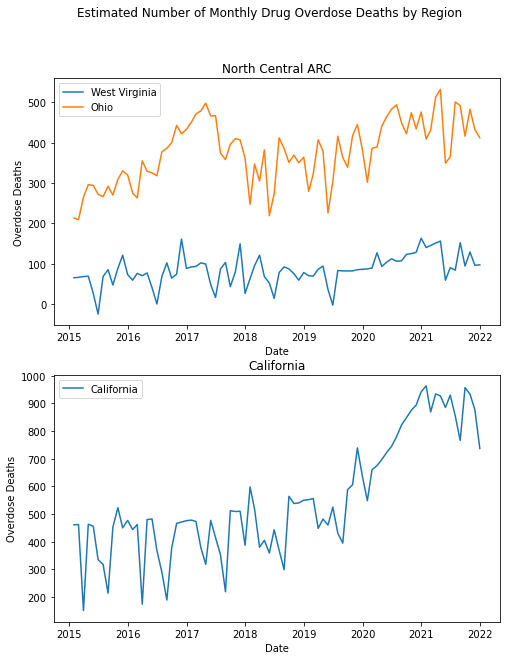

In [17]:
fig, axs = plt.subplots(int(len(sub_regions.keys())/figures_per_row), figures_per_row, figsize=(8,10))
fig.suptitle("Estimated Number of Monthly Drug Overdose Deaths by Region")

for index, sub_region in enumerate(sub_regions.keys()):
    for region in sub_regions[sub_region]:
        axs[index].plot(monthly_deaths_df[monthly_deaths_df["Region"] == region]["End Date"], monthly_deaths_df[monthly_deaths_df["Region"] == region][feature_of_interest], label = region)
    
    axs[index].set_title(sub_region)
    axs[index].legend(loc="upper left")
    axs[index].set(title= sub_region, xlabel='Date', ylabel='Overdose Deaths')
    # change font size

# Slide 17: Python Implementation of More Refined Constraints

In [18]:
period = 12
volatility_factor = 1.2 # must be between 1 and period
regions = death_df["Region"].unique()
indicies = ["State", "FIPS", "Region", "Year", "Month", "Start Date", "End Date", "Percent with drugs specified"]
targets = [element for element in death_df.columns.tolist() if element not in indicies]

monthly_deaths_df = pd.DataFrame()
for region in regions:
    series = death_df[death_df["Region"] == region].sort_values(by='End Date')
    for target in targets:
        sol = series[target].dropna().to_numpy()
        if (len(sol) < 2):
            marginal_values = np.empty(len(series.index))
            marginal_values[:] = np.nan
            series["Estimated Monthly Marginal " + target] = marginal_values
            continue
        coef = sliding_windows(np.ones(period), len(sol))
        #pulp Linear Algebra Solver yeilds a solution not guaranteed to be the correct solution but all the values
        #it produces will be non-negative, discrete and yeild the values in the dataset when summed across a 12 month window
        mod = pulp.LpProblem(region.replace(" ", "_") + ":" +  target.replace(" ", "_"))
        
        #set up contraining inequalities
        #constrain monthly death tally values to integers greater than or equal to 0 
        vars = pulp.LpVariable.dicts('x', range(len(coef[0])), lowBound=0, cat='Integer')
        
        #constrain monthly death tally values to be less than n% greater than themoving average  
        lowBound_vector = np.around(((1/(volatility_factor*period))*np.pad(sol, (period-1,0), 'constant', constant_values=sol[0]) + .5), 0) 
        upBound_vector = np.around(((volatility_factor/period)*np.pad(sol, (period-1,0), 'constant', constant_values=sol[0]) + .5), 0)
        for pointer in vars.keys():
            vars[pointer].lowBound = lowBound_vector[pointer]
            vars[pointer].upBound = upBound_vector[pointer]
            
        #set up contraining equations
        for row, rhs in zip(coef, sol):
            mod += sum([row[i]*vars[i] for i in range(len(row))]) == rhs
            
        mod.solve()
        
        #currently discarding the leading 11 values which dont have corresponding 12 month rolling sums
        #could possibly rewrite this section to keep them with null values for the 12 month rolling sums in the future
        marginal_values = [vars[i].value() for i in range(len(coef[0]))][(period -1):]
        series["Estimated Monthly Marginal " + target] = np.pad(marginal_values, (len(series.index)-len(marginal_values),0), 'constant', constant_values=(np.nan))
    
    monthly_deaths_df = pd.concat([monthly_deaths_df, series])

In [19]:
#Sanity Check 1: Algorithm doesnt return any negative values 
#Table should be empty
calculated_columns = [i for i in monthly_deaths_df.columns if i.startswith("Estimated Monthly Marginal ")]
monthly_deaths_df[((monthly_deaths_df[calculated_columns] >= 0).all(1) == False)][["Region", "Start Date", "End Date"] + calculated_columns].dropna()

,Region,Start Date,End Date,Estimated Monthly Marginal Reported Number of Drug Overdose Deaths,Estimated Monthly Marginal Predicted Number of Drug Overdose Deaths,Estimated Monthly Marginal Cocaine (T40.5),Estimated Monthly Marginal Heroin (T40.1),Estimated Monthly Marginal Methadone (T40.3),Estimated Monthly Marginal Natural & semi-synthetic opioids (T40.2),"Estimated Monthly Marginal Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)","Estimated Monthly Marginal Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)",Estimated Monthly Marginal Number of Deaths,"Estimated Monthly Marginal Opioids (T40.0-T40.4,T40.6)",Estimated Monthly Marginal Psychostimulants with abuse potential (T43.6),"Estimated Monthly Marginal Synthetic opioids, excl. methadone (T40.4)"
191,Georgia,2016-01-01,2016-12-31,138.0,138.0,22.0,22.0,-17.0,44.0,45.0,71.0,7397.0,92.0,25.0,28.0
204,Georgia,2017-02-01,2018-01-31,103.0,104.0,18.0,27.0,-1.0,36.0,39.0,57.0,7103.0,146.0,24.0,27.0
212,Georgia,2017-10-01,2018-09-30,138.0,138.0,24.0,31.0,7.0,31.0,35.0,-8.0,5938.0,93.0,39.0,25.0
289,Kentucky,2017-03-01,2018-02-28,204.0,204.0,12.0,16.0,4.0,27.0,29.0,-17.0,4586.0,78.0,24.0,54.0
302,Kentucky,2018-04-01,2019-03-31,162.0,162.0,9.0,10.0,3.0,29.0,32.0,-10.0,3814.0,0.0,39.0,32.0
346,Maryland,2014-12-01,2015-11-30,129.0,129.0,15.0,40.0,13.0,30.0,56.0,53.0,3305.0,232.0,-2.0,23.0
409,Maryland,2020-03-01,2021-02-28,197.0,197.0,78.0,7.0,20.0,-16.0,62.0,96.0,5520.0,179.0,9.0,90.0
482,Mississippi,2019-04-01,2020-03-31,28.0,30.0,-8.0,5.0,1.0,8.0,8.0,23.0,3152.0,26.0,10.0,15.0
490,Mississippi,2019-12-01,2020-11-30,53.0,54.0,-1.0,5.0,1.0,11.0,9.0,34.0,3793.0,37.0,20.0,27.0
636,Upstate New York,2018-02-01,2019-01-31,144.0,157.0,45.0,44.0,8.0,35.0,41.0,114.0,8242.0,86.0,-25.0,92.0


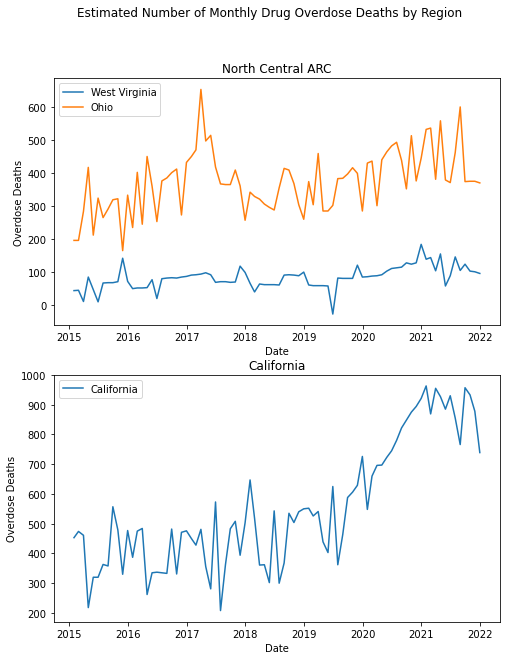

In [20]:
fig, axs = plt.subplots(int(len(sub_regions.keys())/figures_per_row), figures_per_row, figsize=(8,10))
fig.suptitle("Estimated Number of Monthly Drug Overdose Deaths by Region")

for index, sub_region in enumerate(sub_regions.keys()):
    for region in sub_regions[sub_region]:
        axs[index].plot(monthly_deaths_df[monthly_deaths_df["Region"] == region]["End Date"], monthly_deaths_df[monthly_deaths_df["Region"] == region][feature_of_interest], label = region)
    
    axs[index].set_title(sub_region)
    axs[index].legend(loc="upper left")
    axs[index].set(title= sub_region, xlabel='Date', ylabel='Overdose Deaths')
    # change font size